# **Car License Plate Detection**

## **1.Introduction**

We know that the license plate is very important because it will  help us to identify our car from the crowd and will make it unique. That is why License Plate Recognition  is crucial for management in  many areas. For example, with license plate recognition software, you can better enforce parking lot rules all while reducing operating expenses and keeping your clients satisfied. Whether you manage a public parking lot or a parking lot for a school, healthcare facility, or workplace. In addition to ,traffic can flow smoothly without having to stop or it is used to identify the cars that are breaking the traffic rules, as the scanner will capture their license plate number automatically with a license plate recognition system. Improved traffic flow helps reduce potential accidents.However, many of the current solutions are still not robust in real-world situations, commonly depending on many constraints. In the following project, we will understand how to recognize License number plates using deep learning. The results have shown that the model is able to perform with high accuracy of nearly 70-85 percent in recognizing license plates.

 For that, we use the dataset from  [Kaggle](https://www.kaggle.com/datasets/andrewmvd/car-plate-detection) to collect the vehicle images where the number plate appears


In [3]:
#mount google drive
from google.colab import drive 
drive.mount('/content/drive')
#unzip file dataset
 #!unzip -u "/content/drive/My Drive/car_license_plate_detection.zip" -d "/content/drive/My Drive/Detection"

Mounted at /content/drive


In [4]:
# import libary 
import numpy as np # linear algebra
import pandas as pd # data processing

import os
for dirname, _, filenames in os.walk('/content/drive/My Drive/Detection'):
    for filename in filenames:
        os.path.join(dirname, filename)
        #print(dirname)

## **2.Data processing**


First, we need to do some data preprocessing. Since the output of the label is XML in order to use this for the training process we need data in array format. For that, we will take the useful information from the object( license plate) which are the diagonal points of the rectangle box or bounding box which are xmin, ymin, xmax, ymax respectively. This is available in XML. So we need to extract the information and save it in CSV file.

In [5]:
from tqdm.notebook import tqdm # IPython/Jupyter Notebook progressbar decorator for iterators
import xml.etree.ElementTree as xet # implement a simple and efficient API for parsing and creating XML data.
def load_images(directory):
    images = []

    for filepath in tqdm(os.listdir(directory)):
        img_path = os.path.join(directory,filepath)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(224,224))
        img = cv2.medianBlur(img,5)
        images.append(img)
    
    images = np.array(images).reshape(len(images),224,224,3)
    return images
from glob import glob # module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
path = glob('/content/drive/My Drive/Detection/annotations/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
#PARSING INFORMATION FROM XML
for filename in path:
    data = xet.parse(filename)
    root = data.getroot()
    obj = root.find('object')
    labels_info = obj.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [ ]:
os.listdir('/content/drive/My Drive/Detection')

['annotations', 'images']

In [6]:
# CONVERTING DATA FROM XML INTO CSV
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,/content/drive/My Drive/Detection/annotations/...,134,262,128,160
1,/content/drive/My Drive/Detection/annotations/...,226,419,125,173
2,/content/drive/My Drive/Detection/annotations/...,152,206,147,159
3,/content/drive/My Drive/Detection/annotations/...,195,244,266,282
4,/content/drive/My Drive/Detection/annotations/...,167,240,202,220


Next, we want to  verify the bounding box is appearing properly for a given image. For example, we use the image N1.jpeg and the corresponding diagonal position can found in data frame. We can see the result on figure 1

In [7]:
## get all file path image
import cv2
images = load_images('/content/drive/My Drive/Detection/images')
def get_file_name(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/content/drive/My Drive/Detection/images',filename_image)
    return filepath_image

image_path = list(df['filepath'].apply(get_file_name))

  0%|          | 0/433 [00:00<?, ?it/s]

In [8]:
# df['xmin'][6]
df.iloc[0,:]

filepath    /content/drive/My Drive/Detection/annotations/...
xmin                                                      134
xmax                                                      262
ymin                                                      128
ymax                                                      160
Name: 0, dtype: object


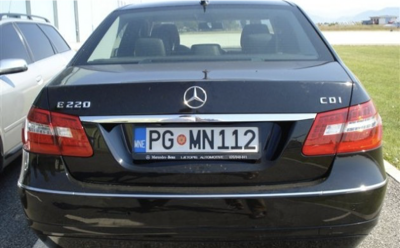

In [9]:
#show a sample image
from skimage import io
import plotly.express as px
file_path = image_path[0] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-134/xmax-262/ymin-128/ymax-160
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
#fig
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 1 - Car1.jpeg with bounding box')
fig.add_shape(type='rect',x0=134, x1=262, y0=128, y1=160, xref='x', yref='y',line_color='cyan')

 Next, we take each image and convert it into an array using OpenCV and resize the image into 224 x 224 which is the standard compatible size of the pre-trained transfer learning model.After that, we normalize the image just by dividing 255 because the maximum number for an 8-bit image can store 256 possible colors, 2 power(8) = 256 -1 = 255 (Min-Max Scaler). We also need to normalize our labels too. Because for the deep learning model the output range should be between 0 to 1. For normalizing labels, we need to divide the diagonal points with the width and height of the image.Then, we will convert the list into an array using Numpy and split the data into training and testing set using sklearn.
 

In [10]:
from sklearn.model_selection import train_test_split
bbox_coords = df.iloc[:,1:].values
labels = []

for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    xmin,xmax,ymin,ymax = bbox_coords[ind]
    nxmin, nxmax = int(xmin/(w/255.)), int(xmax/(w/255.))
    nymin, nymax = int(ymin/(h/255.)), int(ymax/(h/255.))
    labels.append((nxmin,nxmax,nymin,nymax))
labels = np.array(labels)
X = np.array(images,dtype=np.float32)
y = np.array(labels,dtype=np.float32)
X = X / 255.
y = y / 255.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42)

## **VGG16 model**


In [28]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Input
from keras.models import load_model, Sequential
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_16 (Dense)            (None, 128)               3211392   
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 4)                 260       
                                                                 
Total params: 17,951,108
Trainable params: 3,236,420
N

In [ ]:
!pip install scikeras

In [ ]:
def create_model():
  model = Sequential()
  model.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(128, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(4, activation="sigmoid"))

  model.layers[-6].trainable = False

  #model.summary()
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
  return model
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
# create model
model = KerasRegressor(model=create_model, verbose=1)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train,
              y_train,
              
              )
# summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']

Epoch 1/10
25/25 [==============================] - 10s 100ms/step - loss: 0.0697 - accuracy: 0.4476
Epoch 2/10
25/25 [==============================] - 2s 61ms/step - loss: 0.0305 - accuracy: 0.4718
Epoch 3/10
25/25 [==============================] - 2s 61ms/step - loss: 0.0200 - accuracy: 0.6048
Epoch 4/10
25/25 [==============================] - 2s 62ms/step - loss: 0.0153 - accuracy: 0.6653
Epoch 5/10
25/25 [==============================] - 2s 62ms/step - loss: 0.0117 - accuracy: 0.7460
Epoch 6/10
25/25 [==============================] - 2s 61ms/step - loss: 0.0115 - accuracy: 0.7137
Epoch 7/10
25/25 [==============================] - 2s 62ms/step - loss: 0.0104 - accuracy: 0.7500
Epoch 8/10
25/25 [==============================] - 2s 62ms/step - loss: 0.0102 - accuracy: 0.7177
Epoch 9/10
25/25 [==============================] - 2s 62ms/step - loss: 0.0104 - accuracy: 0.7581
Epoch 10/10
7/7 [==============================] - 1s 201ms/step
Epoch 1/10
25/25 [========================

Epoch 1/50
25/25 [==============================] - 2s 66ms/step - loss: 0.0655 - accuracy: 0.5141
Epoch 2/50
25/25 [==============================] - 2s 64ms/step - loss: 0.0287 - accuracy: 0.4819
Epoch 3/50
25/25 [==============================] - 2s 64ms/step - loss: 0.0200 - accuracy: 0.5301
Epoch 4/50
25/25 [==============================] - 2s 65ms/step - loss: 0.0137 - accuracy: 0.6867
Epoch 5/50
25/25 [==============================] - 2s 65ms/step - loss: 0.0135 - accuracy: 0.6948
Epoch 6/50
25/25 [==============================] - 2s 65ms/step - loss: 0.0113 - accuracy: 0.6908
Epoch 7/50
25/25 [==============================] - 2s 65ms/step - loss: 0.0101 - accuracy: 0.7470
Epoch 8/50
25/25 [==============================] - 2s 65ms/step - loss: 0.0089 - accuracy: 0.7671
Epoch 9/50
25/25 [==============================] - 2s 64ms/step - loss: 0.0101 - accuracy: 0.7430
Epoch 10/50
25/25 [==============================] - 2s 64ms/step - loss: 0.0106 - accuracy: 0.7108
Epoch 11/

2/2 [==============================] - 0s 193ms/step
Epoch 1/10
7/7 [==============================] - 2s 189ms/step - loss: 0.1102 - accuracy: 0.3373
Epoch 2/10
7/7 [==============================] - 1s 190ms/step - loss: 0.0662 - accuracy: 0.4940
Epoch 3/10
7/7 [==============================] - 1s 189ms/step - loss: 0.0563 - accuracy: 0.4940
Epoch 4/10
7/7 [==============================] - 1s 189ms/step - loss: 0.0497 - accuracy: 0.4940
Epoch 5/10
7/7 [==============================] - 1s 188ms/step - loss: 0.0431 - accuracy: 0.4940
Epoch 6/10
7/7 [==============================] - 1s 189ms/step - loss: 0.0433 - accuracy: 0.4940
Epoch 7/10
7/7 [==============================] - 1s 188ms/step - loss: 0.0397 - accuracy: 0.4940
Epoch 8/10
7/7 [==============================] - 1s 190ms/step - loss: 0.0389 - accuracy: 0.4940
Epoch 9/10
7/7 [==============================] - 1s 189ms/step - loss: 0.0375 - accuracy: 0.4940
Epoch 10/10
7/7 [==============================] - 1s 189ms/step 

2/2 [==============================] - 0s 239ms/step
Epoch 1/10
7/7 [==============================] - 2s 186ms/step - loss: 0.1672 - accuracy: 0.4859
Epoch 2/10
7/7 [==============================] - 1s 187ms/step - loss: 0.1716 - accuracy: 0.5301
Epoch 3/10
7/7 [==============================] - 1s 187ms/step - loss: 0.1701 - accuracy: 0.5060
Epoch 4/10
7/7 [==============================] - 1s 188ms/step - loss: 0.1649 - accuracy: 0.5060
Epoch 5/10
7/7 [==============================] - 1s 187ms/step - loss: 0.1750 - accuracy: 0.5060
Epoch 6/10
7/7 [==============================] - 1s 193ms/step - loss: 0.1753 - accuracy: 0.5060
Epoch 7/10
7/7 [==============================] - 1s 189ms/step - loss: 0.1753 - accuracy: 0.5060
Epoch 8/10
7/7 [==============================] - 1s 188ms/step - loss: 0.1753 - accuracy: 0.5060
Epoch 9/10
7/7 [==============================] - 1s 188ms/step - loss: 0.1752 - accuracy: 0.5060
Epoch 10/10
2/2 [==============================] - 0s 248ms/step


In [10]:

r = model.fit(X_train,
              y_train,
              epochs=50,
              batch_size=32,
              validation_data=(X_val,y_val),
              verbose=1)

Epoch 1/50
10/10 [==============================] - 16s 542ms/step - loss: 0.0985 - accuracy: 0.4469 - val_loss: 0.0455 - val_accuracy: 0.6571
Epoch 2/50
10/10 [==============================] - 2s 183ms/step - loss: 0.0414 - accuracy: 0.5177 - val_loss: 0.0252 - val_accuracy: 0.6571
Epoch 3/50
10/10 [==============================] - 2s 182ms/step - loss: 0.0302 - accuracy: 0.4920 - val_loss: 0.0268 - val_accuracy: 0.6000
Epoch 4/50
10/10 [==============================] - 2s 184ms/step - loss: 0.0248 - accuracy: 0.4920 - val_loss: 0.0277 - val_accuracy: 0.3714
Epoch 5/50
10/10 [==============================] - 2s 183ms/step - loss: 0.0187 - accuracy: 0.5145 - val_loss: 0.0275 - val_accuracy: 0.4571
Epoch 6/50
10/10 [==============================] - 2s 195ms/step - loss: 0.0149 - accuracy: 0.6109 - val_loss: 0.0274 - val_accuracy: 0.3714
Epoch 7/50
10/10 [==============================] - 2s 186ms/step - loss: 0.0131 - accuracy: 0.6367 - val_loss: 0.0306 - val_accuracy: 0.3714
Epoch

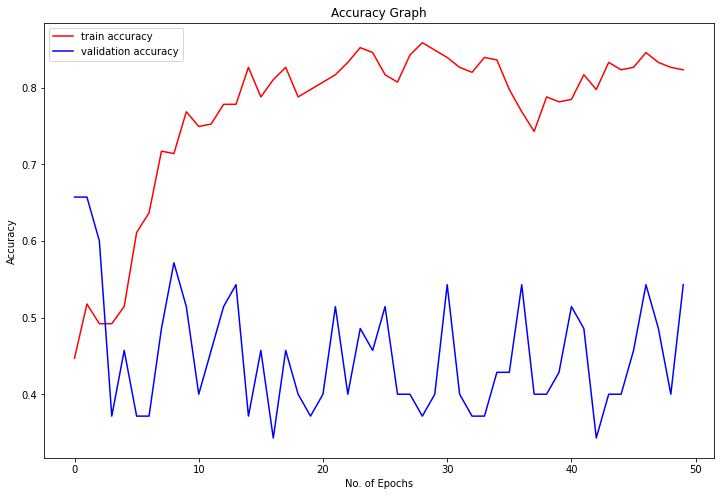

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [12]:
loss, acc = model.evaluate(X_test,y_test)
print("Test Loss:",loss)
print("Test Accuracy:",acc)

3/3 [==============================] - 0s 150ms/step - loss: 0.0344 - accuracy: 0.6437
Test Loss: 0.034417394548654556
Test Accuracy: 0.6436781883239746


In [ ]:

#save the model
model.save('license_plate_detection.h5')
model_detection_1 = load_model('license_plate_detection.h5')
model_detection_1

In [ ]:
#make prediction
# Load model
model = tf.keras.models.load_model('./license_plate_detection.h5')
#load image
path = '../input/number-plate-detection/TEST/TEST.jpeg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')


In [ ]:
## Visualize prediction
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import plotly.express as px
# Visualize the prediction
path = '../input/number-plate-detection/TEST/TEST.jpeg'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

##  **Inception RESNET-V2 model**

In [ ]:
from keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard


In [ ]:
inception_resnet= InceptionResNetV2(input_tensor= Input(shape= (224,224,3)))
model_2 = inception_resnet.output
model_2= Flatten()(model_2)
model_2 = Dense(200, activation= "relu" )(model_2)
model_2 = Dense(100, activation = "relu") (model_2)
model_2= Dense(4, activation= "sigmoid") (model_2)
resnet_model= Model(inputs= inception_resnet.input, outputs= model_2)


225209952/225209952 [==============================] - 7s 0us/step


In [ ]:
import tensorflow as tf

In [ ]:
resnet_model.compile(loss='mse', optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4))
#resnet_model.summary
tfb= TensorBoard("Resnet object dectection")
history= resnet_model.fit(x= X_train, y= y_train, batch_size=10, epochs=100, validation_data= (X_test, y_test), callbacks= [tfb])

Epoch 1/100
32/32 [==============================] - 38s 390ms/step - loss: 0.0442 - val_loss: 0.0356
Epoch 2/100
32/32 [==============================] - 7s 229ms/step - loss: 0.0393 - val_loss: 0.0315
Epoch 3/100
32/32 [==============================] - 8s 252ms/step - loss: 0.0346 - val_loss: 0.0280
Epoch 4/100
32/32 [==============================] - 7s 231ms/step - loss: 0.0313 - val_loss: 0.0264
Epoch 5/100
32/32 [==============================] - 7s 232ms/step - loss: 0.0299 - val_loss: 0.0260
Epoch 6/100
32/32 [==============================] - 7s 234ms/step - loss: 0.0290 - val_loss: 0.0273
Epoch 7/100
32/32 [==============================] - 7s 234ms/step - loss: 0.0287 - val_loss: 0.0264
Epoch 8/100
32/32 [==============================] - 8s 237ms/step - loss: 0.0284 - val_loss: 0.0266
Epoch 9/100
32/32 [==============================] - 8s 238ms/step - loss: 0.0280 - val_loss: 0.0261
Epoch 10/100
32/32 [==============================] - 8s 239ms/step - loss: 0.0278 - val_l

In [ ]:
#save the model
resnet_model.save('resnet_model_detection.h5')
resnet_model_1 = load_model('resnet_model_detection.h5')
resnet_model_1

In [ ]:
loss, acc = resnet_model.evaluate(X_test,y_test)
print("Test Loss:",loss)
print("Test Accuracy:",acc)

3/3 [==============================] - 1s 148ms/step - loss: 0.0342


TypeError: ignored

In [ ]:
#prediction 
path= ''
image= load_images(path)
image= np.array(image, dtype= np.unit8) # 8 bit array (0,255)
image1= load_img(path,target_size= (244,244))
image_arr_224= img_to_array(image1/255)
# Size of the orginal image
h,w,d = image.shape
image.shape

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import plotly.express as px
# Visualize the prediction
path = '../input/number-plate-detection/TEST/TEST.jpeg'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

In [ ]:
import pytesseract as pt #extract text
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')
# extract text from image
text = pt.image_to_string(roi)
print(text)